In [1]:
import math
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

In [2]:
def deduce_uniswap_parameters(k=None, p=None, euro=None, dollar=None):
    """Return a (k, p, euro, dollar)-keyed dictionary where all the parameters 
    are set according to the partial values given in argument."""
    nb_unknown = sum(x is None for x in [p, k, euro, dollar])
    if nb_unknown == 0:
        return {"k":k, "p":p, "euro":euro, "dollar":dollar}
    assert  nb_unknown <= 2, \
        "We need at least two set parameters"
    if euro is not None and dollar is not None and k is None:
        return deduce_uniswap_parameters(k=euro*dollar, p=p, euro=euro, dollar=dollar)
    if euro is not None and dollar is not None and p is None:
        return deduce_uniswap_parameters(k=k, p=dollar/euro, euro=euro, dollar=dollar)
    if dollar is not None and p is not None and euro is None:
        return deduce_uniswap_parameters(k=k, p=p, euro=dollar/p, dollar=dollar)
    if dollar is not None and k is not None and euro is None:
        return deduce_uniswap_parameters(k=k, p=p, euro=k/dollar, dollar=dollar)
    if euro is not None and p is not None and dollar is None:
        return deduce_uniswap_parameters(k=k, p=p, euro=euro, dollar=p*euro)
    if euro is not None and k is not None and dollar is None:
        return deduce_uniswap_parameters(k=k, p=p, euro=euro, dollar=k/euro)
    if p is not None and k is not None:
        return deduce_uniswap_parameters(k=k, p=p, euro=euro, dollar=math.sqrt(k*p))
    raise Exception("WTF ?")
        

In [3]:
def uniswap_diff(old_state, new_state):
    return {f'delta_{k}' : new_state[k] - old_state[k] for k in old_state}

def add_liquidity(old_state, delta_euro=None, delta_dollar=None, delta_k=None):
    """Return the new state after adding the given liquidity.
    Set only one of delta_euro, delta_dollar, or delta_k"""
    new_state = old_state.copy()
    new_state["euro"]   = None if delta_euro   is None else old_state["euro"]   + delta_euro
    new_state["dollar"] = None if delta_dollar is None else old_state["dollar"] + delta_dollar
    new_state["k"]      = None if delta_k      is None else old_state["k"]      + delta_k
    return deduce_uniswap_parameters(**new_state)
  
def change(old_state, delta_euro=None, delta_dollar=None, delta_p=None):
    """Return the new state after changing the given amount
    Set only one of delta_euro, delta_dollar, or delta_p"""
    new_state = old_state.copy()
    new_state["euro"]   = None if delta_euro   is None else old_state["euro"]   + delta_euro
    new_state["dollar"] = None if delta_dollar is None else old_state["dollar"] + delta_dollar
    new_state["p"]      = None if delta_p      is None else old_state["p"]      + delta_p
    return deduce_uniswap_parameters(**new_state)
  

In [54]:
XMAX=40
XMIN=10
ALPHA_DISCOUNT=.5

def plot_contract(state, alpha):
    """Draw a contract state"""
    X=X = np.arange(XMIN, XMAX, .1)
    Y=state["p"]*X
    plt.plot(X, Y, label=r'P=$\frac{\$}{€}$='+f"{state['p']:.1f}", c="tab:orange", alpha=alpha)
    Y=state["k"]/X
    plt.plot(X, Y, label=f"K=€$\cdot$\$={state['k']:.1f}", c="tab:blue", alpha=alpha)
    plt.plot(state["euro"], state["dollar"], marker='o', c="brown", 
             label=f"€={state['euro']:.1f} $={state['dollar']:.1f}", alpha=alpha)

def plot_states(states):
    """Plot the given chronolical list of states"""
    alpha=1
    plt.figure(figsize=(13, 10))
    plt.xlabel("€")
    plt.ylabel("$")
    for s in reversed(states):
        plot_contract(s, alpha)
        alpha*=ALPHA_DISCOUNT
    plt.legend()

In [55]:
def uniswap_transactions(*events):
    """Run the given events, in order, and display the results"""
    events = list(reversed(events))
    s0 = deduce_uniswap_parameters(**events.pop())
    states = [s0]
    print(s0)
    while events:
        func, args = events.pop()
        states.append(func(**{"old_state": states[-1], **args}))
        print(uniswap_diff(states[-2], states[-1]))
        print(states[-1])
    plot_states(states)
    
        

{'k': 100, 'p': 1.0, 'euro': 10, 'dollar': 10}
{'delta_k': 300.0, 'delta_p': 0.0, 'delta_euro': 10.0, 'delta_dollar': 10}
{'k': 400.0, 'p': 1.0, 'euro': 20.0, 'dollar': 20}
{'delta_k': 500.0, 'delta_p': 0.0, 'delta_euro': 10.0, 'delta_dollar': 10.0}
{'k': 900.0, 'p': 1.0, 'euro': 30.0, 'dollar': 30.0}
{'delta_k': 0.0, 'delta_p': 0.2469444444444444, 'delta_euro': -3.134328358208954, 'delta_dollar': 3.5}
{'k': 900.0, 'p': 1.2469444444444444, 'euro': 26.865671641791046, 'dollar': 33.5}
{'delta_k': 0.0, 'delta_p': -0.4848780034211976, 'delta_euro': 7.5, 'delta_dollar': -7.311074918566778}
{'k': 900.0, 'p': 0.7620664410232468, 'euro': 34.365671641791046, 'dollar': 26.188925081433222}
{'delta_k': 0.0, 'delta_p': 0.7172347877667166, 'delta_euro': -9.7, 'delta_dollar': 10.299033287198025}
{'k': 900.0, 'p': 1.4793012287899634, 'euro': 24.665671641791047, 'dollar': 36.48795836863125}


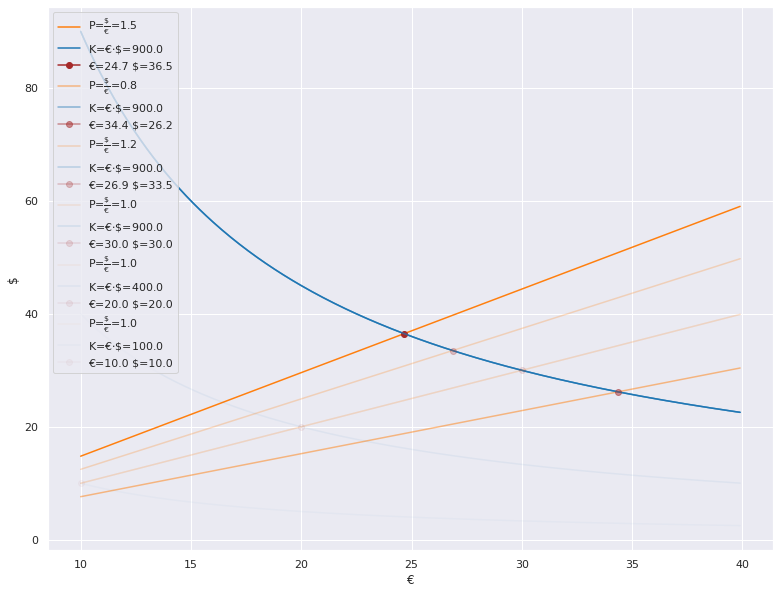

In [64]:
uniswap_transactions(
    {"euro":10, "dollar":10},
    [add_liquidity, {"delta_dollar":10}],
    [add_liquidity, {"delta_euro":10}],
    [change, {"delta_dollar": 3.5}],
    [change, {"delta_euro": 7.5}],
    [change, {"delta_euro": -9.7}],
  #  [change, {"delta_dollar": -7.5}],
  #  [change, {"delta_euro": -7}],
)